In this tutorial, we will explore a few tips for improving your machine learning models. In particular we will cover the following topics:
- Learning curves
- Feature importance
- Hyperparameter tuning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
import time
import numpy as np

def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

def fill_my_missing(df, df_mean_in):
    # This function fills the missing values

    for c in col2use:
        mean_value = df_mean_in.loc[df_mean_in.col == c,'mean_val'].values[0]
        df[c] = df[c].fillna(mean_value)
    return df

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity 

# Prepare data

We will load the training and validation sets. Note that we will not load the test set until we are completely done with tuning our models.

In [2]:
df_train_all = pd.read_csv('df_train_all.csv')
df_valid= pd.read_csv('df_valid.csv')

print('Valid prevalence(n = %d):%.3f'%(len(df_valid),calc_prevalence(df_valid.OUTPUT_LABEL.values)))
print('Train all prevalence(n = %d):%.3f'%(len(df_train_all), calc_prevalence(df_train_all.OUTPUT_LABEL.values)))

# split the training data into positive and negative
rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples 
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)
print('Train balanced prevalence(n = %d):%.3f'%(len(df_train), calc_prevalence(df_train.OUTPUT_LABEL.values)))

Valid prevalence(n = 14901):0.113
Train all prevalence(n = 69540):0.113
Train balanced prevalence(n = 15766):0.500


Let's save our df_train this week. 

In [3]:
df_train.to_csv('df_train.csv',index=False)

In [4]:
col2use = [c for c in list(df_train_all.columns) if c != 'OUTPUT_LABEL']
print('Number of columns to use:', len(col2use))

df_mean = df_train[col2use].mean(axis = 0)
# save the means
df_mean.to_csv('df_mean.csv',index=True)

# load the means so we know how to do it for the test data
df_mean_in = pd.read_csv('df_mean.csv', names =['col','mean_val'])

# fill missing
df_train_all = fill_my_missing(df_train_all, df_mean_in)
df_train = fill_my_missing(df_train, df_mean_in)
df_valid = fill_my_missing(df_valid, df_mean_in)

# create X and y matrices
X_train = df_train[col2use].values
X_train_all = df_train_all[col2use].values
X_valid = df_valid[col2use].values

y_train = df_train['OUTPUT_LABEL'].values
y_valid = df_valid['OUTPUT_LABEL'].values

print('Training All shapes:',X_train_all.shape)
print('Training shapes:',X_train.shape, y_train.shape)
print('Validation shapes:',X_valid.shape, y_valid.shape)

# create scaler
scaler  = StandardScaler()
scaler.fit(X_train_all)

scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

scaler = pickle.load(open(scalerfile, 'rb'))

# transform our data matrices 

X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)

Number of columns to use: 143
Training All shapes: (69540, 143)
Training shapes: (15766, 143) (15766,)
Validation shapes: (14901, 143) (14901,)


C:\Program Files\Anaconda3\envs\pa_2018\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# Learning Curve

In this section, we will make use of the learning curve code from scikit-learn's website. http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html. 

In [5]:
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("AUC")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [6]:
from sklearn.ensemble import RandomForestClassifier

C:\Program Files\Anaconda3\envs\pa_2018\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


A complex Random Forest with max_depth = 20, resulting in high variance. 

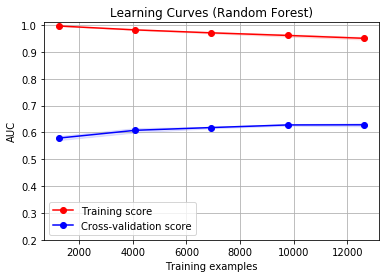

In [7]:
title = "Learning Curves (Random Forest)"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = RandomForestClassifier(max_depth = 20, random_state = 42)
plot_learning_curve(estimator, title, X_train_tf, y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4)

plt.show()

A simple Random Forest with max_depth = 3, resulting in high bias. 

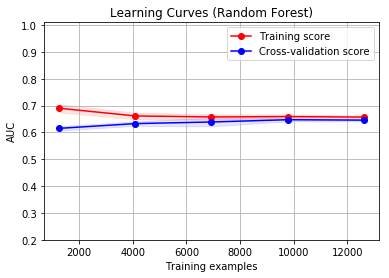

In [8]:
title = "Learning Curves (Random Forest)"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = RandomForestClassifier(max_depth = 3, random_state = 42)
plot_learning_curve(estimator, title, X_train_tf, y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4)

plt.show()

In the first case, we see that there is a large difference between the training and validation scores. This is known as high variance and is a sign of overfitting. In the second case, we can see the training and validation scores are similar but they both have low scores. This is called high bias and is a sign of underfitting. 

Depending on your learning curve, there are a few strategies you can employ to improve your models

High Bias:
- Add new features
- Increase model complexity
- Reduce regularization
- Change model architecture 


High Variance:
- Add more samples
- Add regularization
- Reduce number of features
- Decrease model complexity
- Add better features
- Change model architecture


Source: Andrew Ng's [Coursera class](https://www.coursera.org/specializations/deep-learning?utm_source=gg&utm_medium=sem&campaignid=904733485&adgroupid=54215108588&device=c&keyword=andrew%20ng&matchtype=p&network=g&devicemodel=&adpostion=1t1&creativeid=231631799402&hide_mobile_promo&gclid=Cj0KCQjwk_TbBRDsARIsAALJSOZlkCoqhf68wjopusy6Kzw1qewNAEC-9H0K1LhwOwRZ2llTZtVINicaAiG-EALw_wcB) paraphrased on <https://www.learnopencv.com/bias-variance-tradeoff-in-machine-learning/> and Andrew Ng's Machine Learning Yearning textbook. 


In the remainder of this tutorial, we will discuss some of the hyperparameters (options) for a few of the machine learning models with respect to these strategies above. 

# Feature Importance

One path for improving your models to understand what features are important to your models. This can usually only be investigated for simpler models such as Logistic Regression or Random Forests. This analysis can help in a few areas:
    
    - inspire new feature ideas --> helps with both high bias and high variance
    - obtain a list of the top features to be used for feature reduction --> helps with high variance
    - point out errors in your pipeline --> helps with robustness of model

Let's get the feature importance for a few models and then we can discuss what we see. 


## logistic regression

Logistic regression is a very interpretable model because the coefficient for each variable shows how important that variable is for the prediction. Note that you need to have normalized the data so the coefficients are comparable between variables. 

In [9]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(random_state = 42)
lr.fit(X_train_tf, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

We can extract the coefficients using `coef_` and store in a new dataframe (sorted by importance) 

In [10]:
feature_importances = pd.DataFrame(lr.coef_[0],
                                   index = col2use,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

In [11]:
feature_importances.head()

,importance
number_inpatient,0.356977
rosiglitazone_No,0.283933
rosiglitazone_Steady,0.238042
discharge_disposition_id_22,0.202501
repaglinide_No,0.170694


For logistic regression, the variables with highest positive coefficients are predictive of re-hospitalization and the variables with highest negative coefficients are predictive of not being re-hospitalized. We can plot the top 50 for each direction below. 

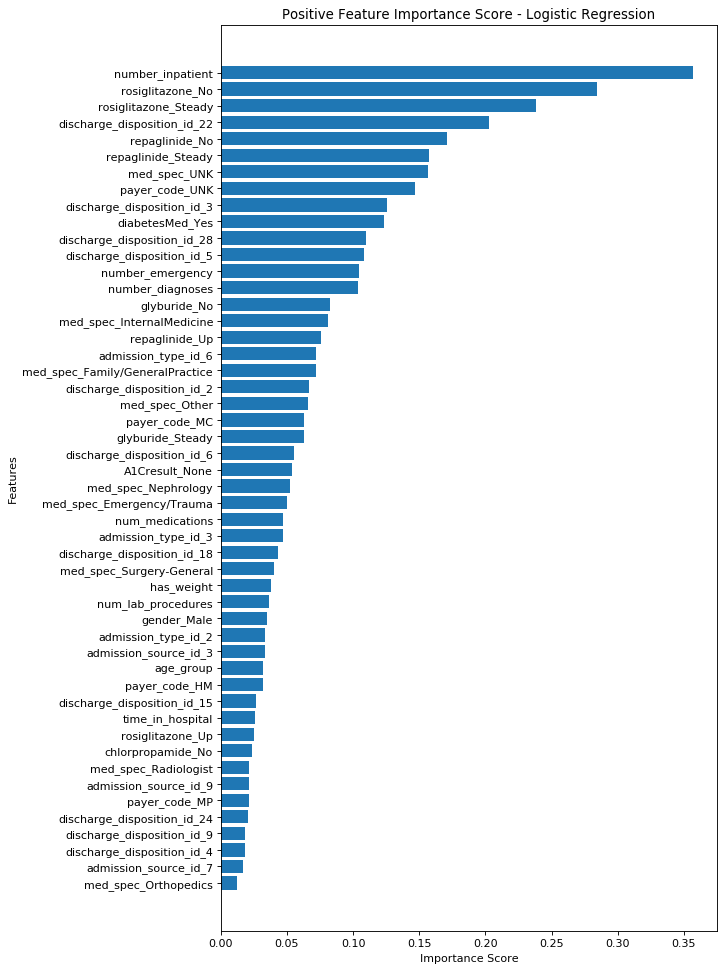

In [12]:
num = 50
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Positive Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

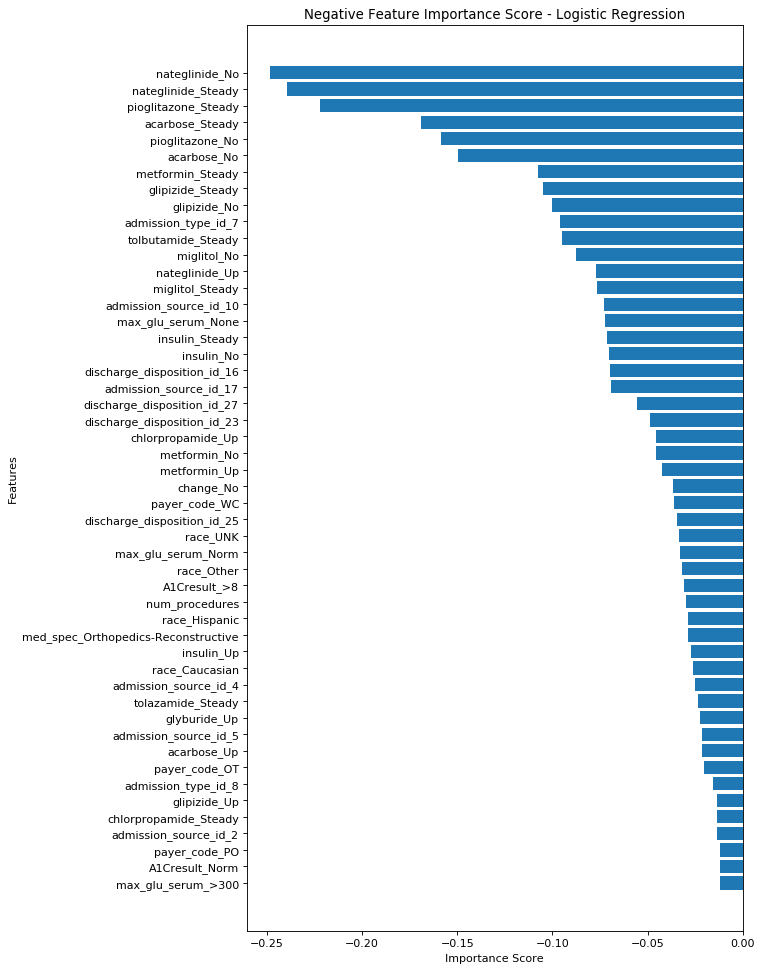

In [13]:
values_to_plot = feature_importances.iloc[-num:].values.ravel()
feature_labels = list(feature_importances.iloc[-num:].index)

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Negative Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

## random forest

We can also investigate feature importance for random forest models. In this case, the feature importance shows how often a particular feature was used to split the data. In this case, we don't know if a particular feature is correlated with the positive class or negative class, but rather it is just importance for making a decision. 

In [14]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth = 6, random_state = 42)
rf.fit(X_train_tf, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [15]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = col2use,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

In [16]:
feature_importances.head()

,importance
number_inpatient,0.300483
number_emergency,0.120202
discharge_disposition_id_22,0.089470
num_medications,0.062188
time_in_hospital,0.054703


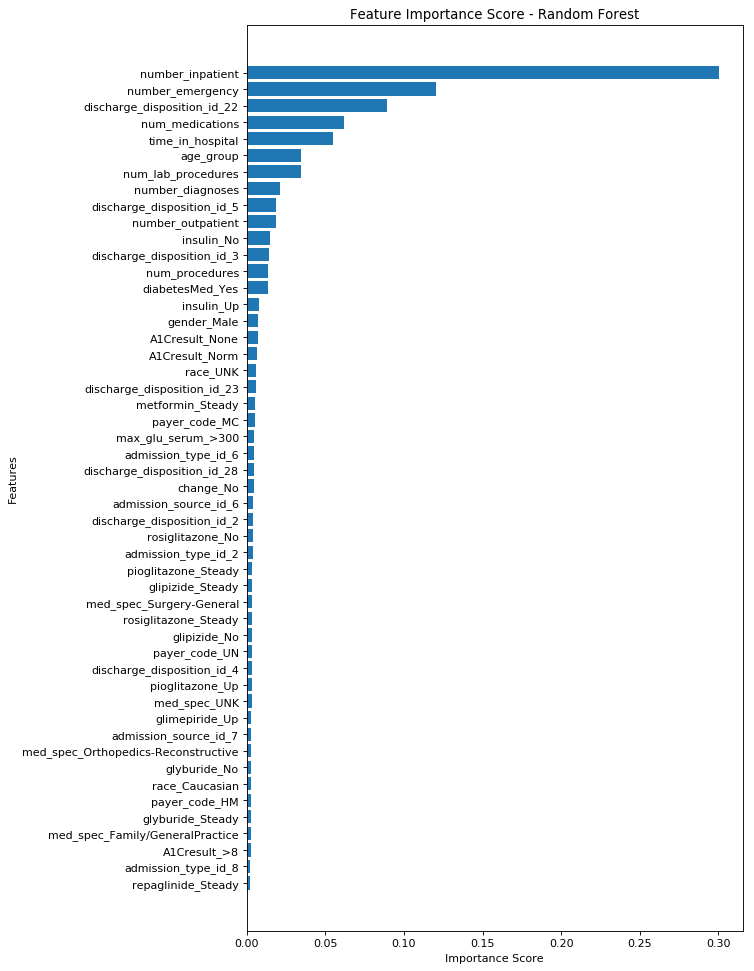

In [17]:
num = 50
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score - Random Forest')
plt.yticks(ylocs, feature_labels)
plt.show()

As you can see here, most of the important variables for random forest are continuous variables. This makes sense since you can split continuous variables more times than categorical variables. 

After reviewing these plots, you might be inspired to get some new data related to the most important features. For example, in both models the most important feature is `number_inpatient`, which is the number of inpatient visits in the last year. This means that if patients have been to the hospital in the last year they are more likely to be re-hospitalized again. This might inspire you to get (if you have it) more data about their prior admissions.Another example is `discharge_disposition_id_22` which is used if a patient is discharged to a rehab facility. For your company, you might be able to research rules for being discharged to a rehab facility and add features related to those rules. Since most of the data analysts / data scientists won't have the deep domain knowledge. I probably would take a few of these features to other experts (e.g. doctors) and ask them about the medications.  

In the case of high variance, one strategy is to reduce the number of variables to minimize overfitting. After this analyis, you could use the top N positive and negative features or the top N important random forest features. You might need to adjust N so that your performance does not drop drastically. For example, only using the top feature will likely drop the performance by a lot. Another strategy that you could use to reduce the number of variables is called PCA (principle component analysis). This is also implemented in scikit-learn if you are interested. 

The last thing that I want to mention is that the feature importance plots may also point out errors in your predictive model. Perhaps, you have some data leakage in the cleaning process. Data leakage can be thought of as the process of accidentally including something in the training that allows the machine learning algorithm to artificially cheat. For example, I built a model based on the doctor's discharge notes. When I performed this same analysis on the most important words, I discovered that the top word for predicting someone would not be re-admitted was 'death'. This made me realize that I made a mistake and forgot to exclude patients who expired in the current hospital visit. Learning from my mistakes, I had you exclude the discharge codes related to death. Similar things can also happen when you merge datasets. Perhaps when you merged the datasets one of the classes ended up with nan for some of the variables. The analysis above will help you catch some of these cases.  

# Hyperparameter tuning

The next thing that we should investigate is hyperparameter tuning. Hyperparameter tuning are essentially the design decisions that you made when you set up the machine learning model. For example, what is the maximum depth for your random forest? Each of these hyperparameters can be optimized to improve the model. 

Let's begin by looking at the effect of a single parameter for random forest: `max_depth`. `max_depth` controls the depth of the tree. 

In [18]:
# train a model for each max_depth in a list. Store the auc for the training and validation set

# max depths
max_depths = np.arange(2,20,2)

train_aucs = np.zeros(len(max_depths))
valid_aucs = np.zeros(len(max_depths))

for jj in range(len(max_depths)):
    max_depth = max_depths[jj]

    # fit model
    rf=RandomForestClassifier(n_estimators = 100, max_depth = max_depth, random_state = 42)
    rf.fit(X_train_tf, y_train)        
    # get predictions
    y_train_preds = rf.predict_proba(X_train_tf)[:,1]
    y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

    # calculate auc
    auc_train = roc_auc_score(y_train, y_train_preds)
    auc_valid = roc_auc_score(y_valid, y_valid_preds)

    # save aucs
    train_aucs[jj] = auc_train
    valid_aucs[jj] = auc_valid

Plot the results

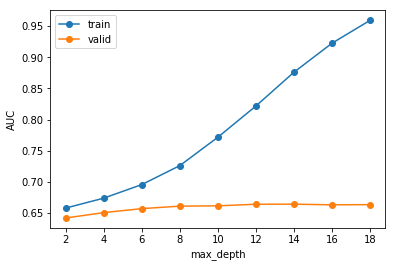

In [19]:
import matplotlib.pyplot as plt

plt.plot(max_depths, train_aucs,'o-',label = 'train')
plt.plot(max_depths, valid_aucs,'o-',label = 'valid')

plt.xlabel('max_depth')
plt.ylabel('AUC')
plt.legend()
plt.show()

We can see that as we increase the `max_depth` the training performance is improved. Unfortunately, for this case, the validation performance does not change much. 

Since there are many hyperparameters for each model, there exist a few techniques to optimize the parameters automatically for you. 

# One of those techniques is called Random Search.

As discussed in lecture, one technique for hyperparameter tuning is called a Grid search where you test all possible combinations over a grid of values. This is very computationally intensive. The other option is to randomly test a permutation of them. This technique called Random Search is also implemented in scikit-learn. Most of this section is based on this medium blog post (https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)by William Koehrsen. I highly recommend following him on Towards Data Science. He writes high quality articles. 

we can get a list of the parameters inside a model with `get_params`. Here are the parameters in the random forest model. Wow there are so many of them! 

In [20]:
rf.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 18,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Let's create a grid over a few of these (see the scikit-learn website for the descriptions). 

In [21]:
from sklearn.model_selection import RandomizedSearchCV

# number of trees
n_estimators = range(200,1000,200)
# maximum number of features to use at each split
max_features = ['auto','sqrt']
# maximum depth of the tree
max_depth = range(2,20,2)
# minimum number of samples to split a node
min_samples_split = range(2,10,2)
# criterion for evaluating a split
criterion = ['gini','entropy']

# random grid

random_grid = {'n_estimators':n_estimators,
              'max_features':max_features,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'criterion':criterion}

print(random_grid)

{'n_estimators': range(200, 1000, 200), 'max_features': ['auto', 'sqrt'], 'max_depth': range(2, 20, 2), 'min_samples_split': range(2, 10, 2), 'criterion': ['gini', 'entropy']}


To use the RandomizedSearchCV function, we need something to score or evaluate a set of hyperparameters. Here we will use the auc. 

In [22]:
from sklearn.metrics import make_scorer, roc_auc_score
auc_scoring = make_scorer(roc_auc_score)

In [23]:
# create a baseline model
rf = RandomForestClassifier()

# create the randomized search cross-validation
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 2, scoring=auc_scoring,verbose = 1, random_state = 42)

Three important parameters of `RandomizedSearchCV` are
- scoring = evaluation metric used to pick the best model
- n_iter = number of different combinations
- cv = number of cross-validation splits

increasing the last two of these will increase the run-time, but will decrease chance of overfitting.  Note that the number of variables and grid size also influences the runtime. Cross-validation is a technique for splitting the data multiple times to get a better estimate of the performance metric. For the purposes of this tutorial, we will restrict to 2 CV to reduce the time. 

In [24]:
# fit the random search model (this will take a few minutes)
t1 = time.time()
rf_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2-t1)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  4.0min finished


248.92398810386658


See the best parameters

In [25]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 6,
 'max_features': 'auto',
 'max_depth': 18,
 'criterion': 'gini'}

Let's analyze the performance of the best model compared to the baseline model.

In [26]:
rf=RandomForestClassifier(max_depth = 6, random_state = 42)
rf.fit(X_train_tf, y_train)

y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

thresh = 0.5

print('Baseline Random Forest')
print('Training AUC:%.3f'%(roc_auc_score(y_train, y_train_preds)))
print('Validation AUC:%.3f'%(roc_auc_score(y_valid, y_valid_preds)))

print('Optimized Random Forest')
y_train_preds_random = rf_random.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_random = rf_random.best_estimator_.predict_proba(X_valid_tf)[:,1]

rf_train_auc = roc_auc_score(y_train, y_train_preds_random)
rf_valid_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f'%(rf_train_auc))
print('Validation AUC:%.3f'%(rf_valid_auc))

Baseline Random Forest
Training AUC:0.681
Validation AUC:0.648
Optimized Random Forest
Training AUC:0.932
Validation AUC:0.668


Note that in this case, we do get a boost of 0.02 on the Validation AUC. It looks like this Optimized Random Forest has massive overfitting, so it would be wise to employ some of the high-variance techniques to try to reduce it. 

# Optimized SGDClassifier and GradientBoostingClassifier too

In [27]:
from sklearn.linear_model import SGDClassifier
sgdc=SGDClassifier(loss = 'log',alpha = 0.1,random_state = 42)
sgdc.fit(X_train_tf, y_train)

C:\Program Files\Anaconda3\envs\pa_2018\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [28]:
penalty = ['none','l2','l1']
max_iter = range(200,1000,200)
alpha = [0.001,0.003,0.01,0.03,0.1,0.3]
random_grid_sgdc = {'penalty':penalty,
              'max_iter':max_iter,
              'alpha':alpha}
# create the randomized search cross-validation
sgdc_random = RandomizedSearchCV(estimator = sgdc, param_distributions = random_grid_sgdc, n_iter = 20, cv = 2, scoring=auc_scoring,verbose = 0, random_state = 42)

t1 = time.time()
sgdc_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2-t1)

155.6969940662384


In [29]:
sgdc_random.best_params_

{'penalty': 'l1', 'max_iter': 400, 'alpha': 0.001}

In [30]:
y_train_preds = sgdc.predict_proba(X_train_tf)[:,1]
y_valid_preds = sgdc.predict_proba(X_valid_tf)[:,1]

thresh = 0.5

print('Baseline sgdc')
print('Training AUC:%.3f'%(roc_auc_score(y_train, y_train_preds)))
print('Validation AUC:%.3f'%(roc_auc_score(y_valid, y_valid_preds)))

print('Optimized sgdc')
y_train_preds_random = sgdc_random.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_random = sgdc_random.best_estimator_.predict_proba(X_valid_tf)[:,1]
sgdc_train_auc = roc_auc_score(y_train, y_train_preds_random)
sgdc_valid_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f'%(sgdc_train_auc))
print('Validation AUC:%.3f'%(sgdc_valid_auc))

Baseline sgdc
Training AUC:0.676
Validation AUC:0.662
Optimized sgdc
Training AUC:0.677
Validation AUC:0.664


In [31]:
from sklearn.ensemble import GradientBoostingClassifier
gbc =GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=3, random_state=42)
gbc.fit(X_train_tf, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1.0, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

Note this one takes a long time, so work on your capstone project while this is computing. 

In [32]:
# number of trees
n_estimators = range(100,500,100)

# maximum depth of the tree
max_depth = range(1,10,1)

# learning rate
learning_rate = [0.001,0.003,0.01,0.03,0.1,0.3]

# random grid

random_grid_gbc = {'n_estimators':n_estimators,
              'max_depth':max_depth,
              'learning_rate':learning_rate}

# create the randomized search cross-validation
gbc_random = RandomizedSearchCV(estimator = gbc, param_distributions = random_grid_gbc, n_iter = 20, cv = 2, scoring=auc_scoring,verbose = 0, random_state = 42)

t1 = time.time()
gbc_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2-t1)

1070.7135663032532


In [33]:
gbc_random.best_params_

{'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1}

In [34]:
y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

thresh = 0.5

print('Baseline gbc')
print('Training AUC:%.3f'%(roc_auc_score(y_train, y_train_preds)))
print('Validation AUC:%.3f'%(roc_auc_score(y_valid, y_valid_preds)))

print('Optimized gbc')
y_train_preds_random = gbc_random.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_random = gbc_random.best_estimator_.predict_proba(X_valid_tf)[:,1]
gbc_train_auc = roc_auc_score(y_train, y_train_preds_random)
gbc_valid_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f'%(gbc_train_auc))
print('Validation AUC:%.3f'%(gbc_valid_auc))

Baseline gbc
Training AUC:0.772
Validation AUC:0.639
Optimized gbc
Training AUC:0.730
Validation AUC:0.669


# Analyze results

Let's make a dataframe with these results and plot the outcomes using seaborn. 

In [35]:
df_results = pd.DataFrame({'classifier':['SGD','SGD','RF','RF','GB','GB'],
                           'data_set':['train','valid']*3,
                          'auc':[sgdc_train_auc,sgdc_valid_auc,rf_train_auc,rf_valid_auc,gbc_train_auc,gbc_valid_auc,],
                          })

In [36]:
df_results

,classifier,data_set,auc
0,SGD,train,0.676909
1,SGD,valid,0.663588
2,RF,train,0.931803
3,RF,valid,0.667565
4,GB,train,0.729769
5,GB,valid,0.669123


In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

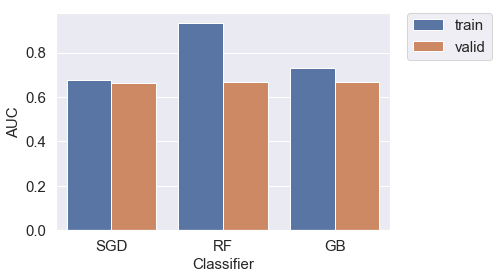

In [38]:
ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)

plt.show()

# Save your best classifier

You won't want to train your best classifier every time you want to run new predictions. Therefore, we need to save the classifier. We will use the package pickle. Here we will chose the stochastic gradient descent algorithm since it has the closest Training / Validation scores and performs about the same as the random forest and gradient boosting classifier. 

In [39]:
pickle.dump(sgdc_random.best_estimator_, open('best_classifier.pkl', 'wb'),protocol = 4)